# Regularized Linear Models
As you saw in chapters 1 and 2, a good way to reduce overfitting is to regularize the model (i.e., to constraint it): The fewer degress of freedom it has, the harder it will be for it to overfit the data. A simple way to regularize a polynomial model is to reduce the polynomial degress. 

For a linear model, regularization is typically achieved by constraining the weights of the model. We will now look at ridge regression, lasso regression, and elastic net regression, which impolement three different ways to constrain the weights. 

## Ridge Regresssion:
*Ridge Regression* (also called *tikhonov regularization*) is a regularized version of linear regresssion: 
- A regularization term equal to $\frac{\alpha}{m} \sum^n_{i=1} \theta_i^2$ is added to the MSE. 
    - This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. Note that the regularization term should only be added to the cost function during training. Once the model is trained, y ou want to use the unregularized MSE (or the RMSE) to evaluate the model's performance. 
    - The hyperparameter $\alpha$ controls how much regularization is added to the model.
        - If $\alpha = 0$, then ridge regression is just linear regression.
        - if $\alpha$ is very large, then all weights end up very close to zero and the result is a flat line going through the data's mean.


#### *Equation 1 | Ridge Regression Cost Function*
$$ J(\theta) \quad = \quad \text{MSE}(\theta) + \frac{\alpha}{m} \sum^n_{i=1} \theta_i^2 $$

- Note that the bias term $\theta_0$ is not regularized (the sum starts at $i = 1$, not 0). 
- If we define $\text{w}$ as the vector of feature weights $(\theta_1$ to $\theta_n)$, then the regularization term is equal to $\alpha ( \| \text{w} \|_2)^2$  \ $m$, where   $\| \text{w} \|_2$ represents the $l_2$ norm of the weight vector. 
- For batch gradient descent, just add $2 \alpha w$ \ $m$ to the part of the MSE gradient vector that corresponds to the feature weights, without adding anything to the gradient of the bias term. 
    - It is important to scaled the data (e.g, using `StandardScaler`) before performing ridge regression, as it is sensitive to the scale of the input features. This is true of most regularized models.


The below chart shows several ridge models that were trained on some very noisy linear data using different $\alpha$ values. On the left, plain ridge models are used, leading ot linear patterns. On the the right, the data is first expanded using `PolynomialFeatures(degree=10)`, then it is scaled using a `StandardScaler`, and finally the ridge models are applied to the resulting features: this is polynomial regression with ridge regularization. Note how increasing $\alpha$ leads to flatter (i.e., less extreme, more reasonable) predictions, thus reducing the model's variance but increasing its bias. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
# extra code – we've done this type of generation several times before
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

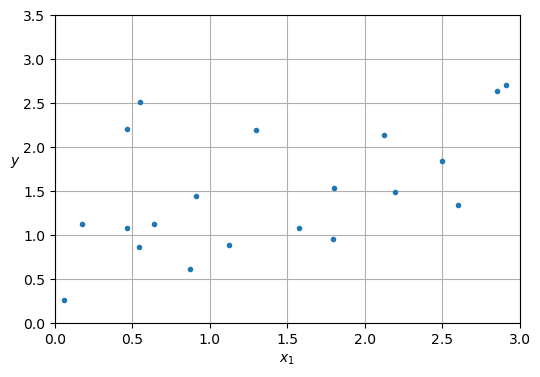

In [3]:
# extra code – a quick peek at the dataset we just generated
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

In [4]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

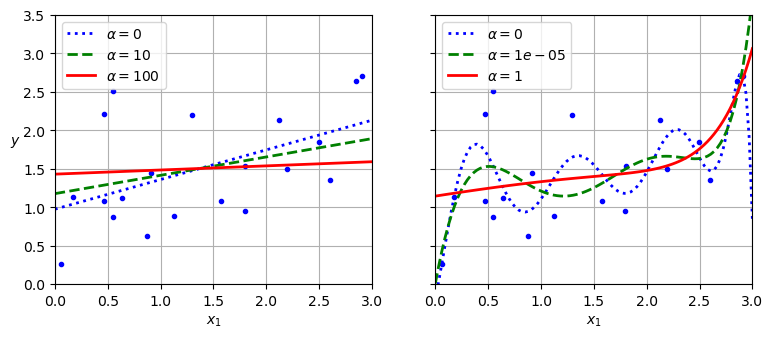

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
# extra code – this cell generates and saves Figure 4–17

def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
#save_fig("ridge_regression_plot")
plt.show()

As with linear regression, we can perform ridge regression either by computing a closed-form equation or by performing gradient descent. The pros and cons are the same. Equation 2 shows the closed from solution, where $\text{A}$ is the $(n + 1) \times (n + 1)$ *identity matrix*, except with a 0 in the top-left cell, corresponding to the bias term.

#### *Equation 2 | Ridge Regression Closed-Form Solution*

$\hat{\theta} \quad = \quad (X^{\top})X + \alpha A)^{-1} X^{\top} y$

Here is how to perform ridge regression with Scikit-Learn using a closed-form solution (a variant of the above equation that uses a matrix factorization technique by Andre-Louis Cholesky):

In [10]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

And using stochastic gradient descent

In [13]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets
sgd_reg.predict([[1.5]])

array([1.55302613])

The `penalty` hyperparameter sets the type of regularization term to use. Specifying `l2` indicates that you want SGD to add a regularization term to the MSE cost function equal to `alpha` times the square of the $\ell_2$ norm of the weight vector. This is just like ridge regression, except there's no division by $m$ in this case; that's why we passed `alpha = 0.1 / m`, to get the same result as `Ridge(alpha=0.1)`. 
    The `RidgeCV` class also performs ridge regression, but it automatically tunes hyperparameters using cross-validation. It's roughly equivalent to using `GridSearchCV`, but it's optimized for ridge regresssion and runs *much* faster. SEveral other estimators (mostly linear) have efficient CV variants, such as `LassoCV` and `ElasticNetCV`. 

## Lasso Regression
L - *Least*

A - *Absolute*

S - *Shrinkage*

(and)

S - *Selection*

O - *Operator*

*Regression*

is another regularized version of linear regression: just like ridge regression, it adds a regularization term to the cost function, but it uses the $\ell_1$ norm of the weight vector instead of the square of the $\ell_2$ norm. Notice that the $\ell_1$ norm is multiplied by $2 \alpha$ , whereas the $\ell_2$ norm was multiplied by $\alpha$ \ $m$ in ridge regression. These factors were chosen to ensure that the optimal $\alpha$ value is independent from the training set size: different norms lead to different factors. 

#### *Equation 3 | Lasso Regression Cost Function*

$J(\theta) \quad = \quad \text{MSE} (\theta) + 2\alpha \sum^n_{i = 1} |\theta_i|$

The below chart shows the same model as the above chart, but replaces the ridge models with lasso models and uses different $\alpha$ values. 

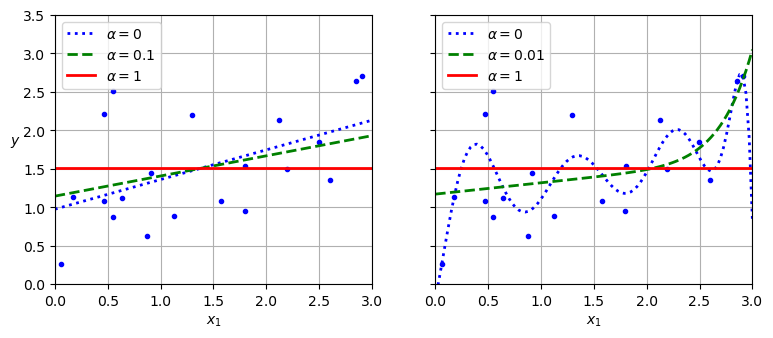

In [16]:
# extra code – this cell generates and saves Figure 4–18
plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
#save_fig("lasso_regression_plot")
plt.show()

*Linear (left) and polynomial (right) models, both using various levels of lasso regularization.*

An important characteristic of lasso regression is that it tends to eliminate the weights of the least important features (i.e., set them to zero). For example, the dashed line in the righthand plot (with $\alpha = 0.01$) looks roughly cubic: all the weights for the high-degree polynomial model features are equal to zero. In other words, lasso regression automatically performs feature selection and outputs a *sparse model* with few nonzero weights. 

You can get a sense of why this is the case by looking at the below chart:

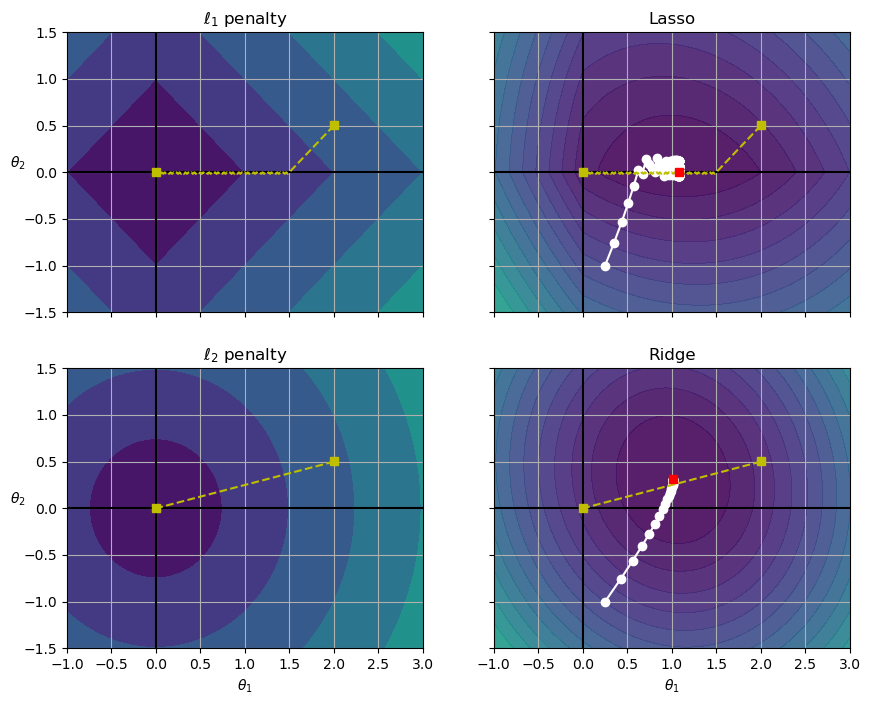

In [18]:
# extra code – this BIG cell generates and saves Figure 4–19

t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1 / len(Xr) * ((T @ Xr.T - yr.T) ** 2).sum(axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(J.argmin(), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = (core * 2 / len(X) * X.T @ (X @ theta - y)
                     + l1 * np.sign(theta) + l2 * theta)
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))

for i, N, l1, l2, title in ((0, N1, 2.0, 0, "Lasso"), (1, N2, 0, 2.0, "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2 ** 2

    tr_min_idx = np.unravel_index(JR.argmin(), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levels = np.exp(np.linspace(0, 1, 20)) - 1
    levelsJ = levels * (J.max() - J.min()) + J.min()
    levelsJR = levels * (JR.max() - JR.min()) + JR.min()
    levelsN = np.linspace(0, N.max(), 10)

    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(theta=np.array([[2.0], [0.5]]), X=Xr, y=yr,
                      l1=np.sign(l1) / 3, l2=np.sign(l2), core=0)
    ax = axes[i, 0]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, N / 2.0, levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(fr"$\ell_{i + 1}$ penalty")
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$", rotation=0)

    ax = axes[i, 1]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")

#save_fig("lasso_vs_ridge_plot")
plt.show()

The axes represent two model parameters, and the contour represent different loss functions. 

In the top left plot, the contours represent the $\ell_1$ loss ($ | \theta_1 | + | \theta_2 |$), which drops linearly as you get closer to any axis.

For example, if you initialize the model parameters to: 

- $\theta_1 = 2$, and 
- $\theta_2 = 0.5$, 

Running gradient descent will decrement both parameters equally (as represented by the dashed yellow line); therefore $\theta_2$ will reach 0 first (since it was closer to 0 to begin with). After that, gradient descent will roll down the gutter until it reaches $\theta_1 = 0$ (with a a bit of bouncing around, since the ingredients of $\ell_1$ never get close to 0: they are either -1 or 1 for each parameter). 

In the top right plot, the contours represent lasso regression's cost function (i.e., an MSE cost function plus an $\ell_1$ loss). 

The small white circles show the path that gradient descent takes to optimize some model parameters that were initialized around $\theta_1 = 0.25$ and $\theta_2 = -1$: notice once again how the path quickly reaches $\theta_2 = 0$ then rolls down the gutter and ends up bouncing around the global optimum (represented by the red square). 

If we increased $\alpha$, the global optimum would move left along the dashed yhellow line. while if we decreased $\alpha$, the global optimum would move right (in this example, the optimal parameters for the unregularized MSE are $\theta_1 = 2$ and $\theta_2 = 0.5$. 


The two bottom plots show the same thing but with an $\ell_2$ penalty instead. In the bottomwleft plot, you can see that the $\ell_2$ loss decreases as we get closer to the origin, so gradient descent just takes a stright path toward that point. In the bottom-irght plot, the contours represent ridge regression's cost function (i.e., an MSE cost function plus an $\ell_2$ loss). As you can see, the gradients get smaller as the parameters approach the global optimum, so gradient descent naturally slows down. This limits the bouncing around, which helps ridge converge faster than lasso regression. 

Also note that the optimal parameters (represented by the red square) get closer and closer to the origin when you increase $\alpha$ but they never get eliminated entirely. 

> To keep gradient descent from bouncing around the optimum at the end when using lasso regression, you need to gradually reduce the learning rate during training. It will still bounce around the optimum, but the stpes will get smaller and smaller, so it will converge. 

The lasso cost function is not differentiable at $\theta_i = 0$ (for $i = 1, 2, \cdots, n$) but gradient descent still works if  you use a *subgradient vector* $\mathbf{g}$ instead when any $\theta_i = 0$. Equation 4 shows a subgradient vector equation you can use for gradient descent with the lasso cost function. 

#### *Equation 4 | Lasso regression with subgradient vector*

$$
g(\theta, j) 
= \nabla_\theta \mathrm{MSE}(\theta) 
  + 2\alpha 
  \begin{pmatrix}
    \mathrm{sign}(\theta_1) \\
    \mathrm{sign}(\theta_2) \\
    \vdots \\
    \mathrm{sign}(\theta_n)
  \end{pmatrix}

\quad \mathrm{where} \quad

\mathrm{sign}(\theta_i) = 
\begin{cases}
-1 & \text{if } \theta_i < 0, \\
0 & \text{if } \theta_i = 0, \\
+1 & \text{if } \theta_i > 0.
\end{cases}
$$

Here is a small Scikit-Learn example using the `Lasso` class:

In [14]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

Note that you could instead use `SGDRegressor(penalty="l1", alpha=0.1)`.

## Elastic Net Regression
*Elastic net regression* is a middle ground between ridge regression and lasso regression. The regularization term is a weighted sum of both ridge and lasso's regularization terms, and you can control the mix ratio $r$. 

When $r = 0$, elastic net is equivalent to ridge regerssion, and when $r = 1$, it is equivalent to lasso regression

#### *Equation 5 | Elastic net cost function*

$J(\theta) \quad = \quad \text{MSE}(\theta) + r(2\alpha\sum^n_i |\theta_i|) + (1 - r) (\frac{\alpha}{m} \sum^n_{i=1} \theta^2_i)$

So when you should use elastic net regresion, or ridge, or lasso, or plain linear regression (i.e., without any regularization)? It is almost always preferable to have at least a little bit of regularization, so generally you should avoid plain linear regression. Ridge is a good default, but if you suspect that only a few featuresa are useful you should prefer lasso or elastic net because they tend to reduce the useless features' weights down to zero, as discussed earlier.

In general, elastic net is preferred over lasso because lasso may behave erratically when the number of features is greater than the number of training instances or when several features are storngly correlated. 

here is a short exmaple that uses Scikit-Learn's `ElasticNet`(`l1_ratio` corresponds to the mix ratio $r$):

In [19]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## Early Stopping

A very different way to regularize iterative learning algorithms such a gradient descent is to stop training as soon as the validation error reaches a minimum. That is called *early stopping*. The below chart shows a compelx model (in this case a high-degree polynomial regression model) being traing with batch gradient descent on the quadratic dataset we used earlier. As the epochs go by, the algorithm learns, and its prediction error (RMSE) on the trianing set goes down, along with its prediction error on the validation set. 

After a while though, the validation error stops decreasing and starts to go back up. This indicates that hte model has started to overfit the trianing data. With early stopping you just stop trianing as soon as the validation error reaches the minimum. It is such a simple and efficient regualarization technique that Geoffry Hinton called it a "beautiful free lunch".


Here's a basic implementation of early stopping: 

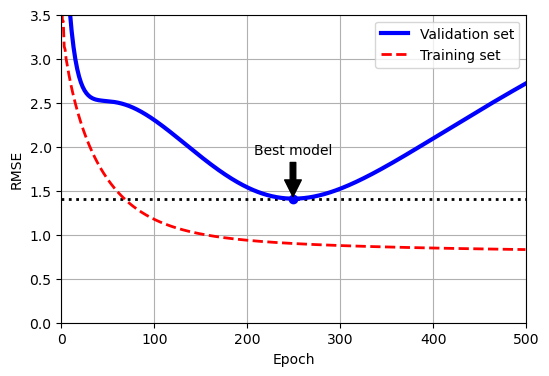

In [30]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

# extra code – creates the same quadratic dataset as earlier and splits it
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []  # extra code – it's for the figure below

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = root_mean_squared_error(y_valid, y_valid_predict)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    # extra code – we evaluate the train error and save it for the figure
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = root_mean_squared_error(y_train, y_train_predict)
    val_errors.append(val_error)
    train_errors.append(train_error)

# extra code – this section generates and saves Figure 4–20
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
#save_fig("early_stopping_plot")
plt.show()

Here'ds a basic implementation of early stopping: 